In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
i =0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        i+=1
print(i)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project-1-saving-slices/__results__.html
/kaggle/input/project-1-saving-slices/__notebook__.ipynb
/kaggle/input/project-1-saving-slices/__output__.json
/kaggle/input/project-1-saving-slices/custom.css
/kaggle/input/project-1-saving-slices/__results___files/__results___9_0.png
/kaggle/input/project-1-saving-slices/__results___files/__results___7_1.png
/kaggle/input/project-1-saving-slices/__results___files/__results___8_1.png
/kaggle/input/project-1-saving-slices/valid/mask/img/colon13-slice084_z.png
/kaggle/input/project-1-saving-slices/valid/mask/img/colon5-slice199_z.png
/kaggle/input/project-1-saving-slices/valid/mask/img/colon14-slice011_z.png
/kaggle/input/project-1-saving-slices/valid/mask/img/colon0-slice076_z.png
/kaggle/input/project-1-saving-slices/valid/mask/img/colon1-slice027_z.png
/kaggle/input/project-1-saving-slices/valid/mask/img/colon20-slice016_z.png
/kaggle/input/project-1-saving-slices/valid/mask/img/colon6-slice004_z.png
/kaggle/input/project-1-savin

In [2]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
!pip install keras-unet-collection
import keras_unet_collection
from keras_unet_collection import models
from keras_unet_collection import losses
from sklearn.metrics import recall_score, jaccard_score, f1_score, hamming_loss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.3 MB/s eta 0:00:00


In [3]:
def count_images_in_folder(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    image_count = 0

    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

    return image_count

In [4]:
folder_path = "/kaggle/input/project-1-saving-slices/test/img/img"
num_images = count_images_in_folder(folder_path)

print(f'There are {num_images} images in the folder.')

There are 6616 images in the folder.


In [5]:
folder_path = "/kaggle/input/project-1-saving-slices/train/img/img"
num_images = count_images_in_folder(folder_path)

print(f'There are {num_images} images in the folder.')

There are 10162 images in the folder.


In [6]:
#Defining Constants
SEED = 42
BATCH_SIZE = 32
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
CHANNEL = 1
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

#train path
train_dir = "/kaggle/input/project-1-saving-slices/train/"
train_img_dir = os.path.join(train_dir, 'img')
train_mask_dir = os.path.join(train_dir, 'mask')

#valid path
valid_dir = "/kaggle/input/project-1-saving-slices/valid/"
valid_img_dir = os.path.join(valid_dir, 'img')
valid_mask_dir = os.path.join(valid_dir, 'mask')

#test path
test_dir = "/kaggle/input/project-1-saving-slices/test/"
test_img_dir = os.path.join(test_dir, 'img')
#test_mask_dir = os.path.join(test_dir, 'mask')

In [7]:
def create_segmentation_generator_train_and_valid(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1/255.0)

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

    img_generator = datagen.flow_from_directory(img_path,
                                                target_size=IMG_SIZE,
                                                class_mode=None,
                                                color_mode='grayscale',
                                                batch_size=BATCH_SIZE,
                                                shuffle= False,
                                                seed=SEED)


    msk_generator = datagen.flow_from_directory(msk_path,
                                                target_size=IMG_SIZE,
                                                class_mode=None,
                                                color_mode='grayscale',
                                                batch_size=BATCH_SIZE,
                                                shuffle= False,
                                                seed=SEED)

    return zip(img_generator, msk_generator)

In [8]:
def create_segmentation_generator_test(img_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1/255.0)
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

    img_generator = datagen.flow_from_directory(img_path,
                                                target_size=IMG_SIZE,
                                                class_mode=None,
                                                color_mode='grayscale', 
                                                batch_size=BATCH_SIZE,
                                                shuffle= False,
                                                seed=SEED)
    #msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return img_generator

In [9]:
train_generator = create_segmentation_generator_train_and_valid(train_img_dir, train_mask_dir, BATCH_SIZE)
valid_generator = create_segmentation_generator_train_and_valid(valid_img_dir, valid_mask_dir, BATCH_SIZE)
test_generator = create_segmentation_generator_test(test_img_dir, BATCH_SIZE)

Found 10162 images belonging to 1 classes.
Found 10162 images belonging to 1 classes.
Found 3324 images belonging to 1 classes.
Found 3324 images belonging to 1 classes.
Found 6616 images belonging to 1 classes.


In [10]:
def display(display_list):
    plt.figure(figsize=(8,8))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

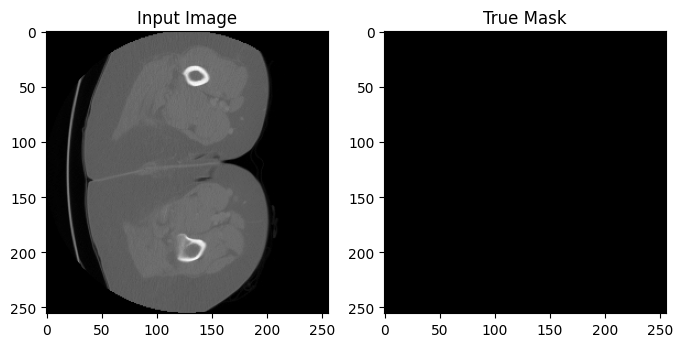

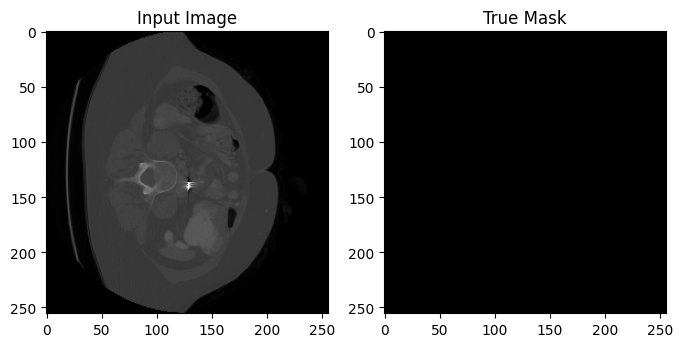

In [11]:
show_dataset(train_generator, 2)

In [12]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs

    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')

    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = tf.keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = tf.keras.layers.MaxPool2D(pooling_size)(x)

    # upstream
    for level in reversed(range(n_levels-1)):
        x = tf.keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = tf.keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = tf.keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)

    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = tf.keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)

    return tf.keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [13]:
"""model = unet(4)"""

'model = unet(4)'

In [14]:
"""model = models.att_unet_2d(input_size= (256,256,3),filter_num=[64, 128, 256, 512, 1024], n_labels=1,
                           stack_num_down=2, stack_num_up=2, activation='ReLU',
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid',
                           batch_norm=False, pool=False, unpool=False,
                           backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='attunet')"""
"""model = models.unet_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024],
                           n_labels=1,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='unet')"""
"""model = models.vnet_2d((256, 256, 1), filter_num=[16, 32, 64, 128, 256], n_labels=2,
                      res_num_ini=1, res_num_max=3,
                      activation='PReLU', output_activation='Softmax',
                      batch_norm=True, pool=False, unpool=False, name='vnet')"""

"model = models.vnet_2d((256, 256, 1), filter_num=[16, 32, 64, 128, 256], n_labels=2,\n                      res_num_ini=1, res_num_max=3,\n                      activation='PReLU', output_activation='Softmax',\n                      batch_norm=True, pool=False, unpool=False, name='vnet')"

In [15]:
#Import vgg model by not defining an input shape. 
vgg_model = VGG16(include_top=False, weights='imagenet')
print(vgg_model.summary())

#Get the dictionary of config for vgg16
vgg_config = vgg_model.get_config()

# Change the input shape to new desired shape
h, w, c = IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL
vgg_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)


#Create new model with the updated configuration
vgg_updated = Model.from_config(vgg_config)
print(vgg_updated.summary())

# Check Weights of first conv layer in the original model...
orig_model_conv1_block1_wts = vgg_model.layers[1].get_weights()[0]

print(orig_model_conv1_block1_wts[:,:,0,0])
print(orig_model_conv1_block1_wts[:,:,1,0])
print(orig_model_conv1_block1_wts[:,:,2,0])

# Check Weights of first conv layer in the new model...
new_model_conv1_block1_wts = vgg_updated.layers[1].get_weights()[0]
print(new_model_conv1_block1_wts[:,:,0,0])
#Notice the Random weights....

#Let us average weights for all RGB channels for the first convolutional layer
#and assign it to the first conv layer in our new model. 

# Function that calculates average of weights along the channel axis  
def avg_wts(weights):  
  average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)  #Find mean along the channel axis (second to last axis)
  return(average_weights)

#Get the configuration for the updated model and extract layer names. 
#We will use these names to copy over weights from the original model. 
vgg_updated_config = vgg_updated.get_config()
vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]

#Name of the first convolutional layer.
#Remember that this is the only layer with new additional weights. All other layers
#will have same weights as the original model. 
first_conv_name = vgg_updated_layer_names[1]

#Update weights for all layers. And for the first conv layer replace weights with average of all 3 channels. 
for layer in vgg_model.layers:
    if layer.name in vgg_updated_layer_names:
     
      if layer.get_weights() != []:  #All convolutional layers and layers with weights (no input layer or any pool layers)
        target_layer = vgg_updated.get_layer(layer.name)
    
        if layer.name in first_conv_name:    #For the first convolutionl layer
          weights = layer.get_weights()[0]
          biases  = layer.get_weights()[1]
          
          weights_single_channel = avg_wts(weights)
                                                    
          target_layer.set_weights([weights_single_channel, biases])  #Now set weights for the first conv. layer
          target_layer.trainable = False   #You can make this trainable if you want. 
    
        else:
          target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
          target_layer.trainable = False  #You can make this trainable if you want. 


# Check Weights of first conv layer in the new model...
#Compare against the original model weights
vgg16 = vgg_updated.layers[1].get_weights()[0]
print(vgg16[:,:,0,0])

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [16]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [17]:
def build_vgg16_unet():
    """ Input """
    inputs = vgg_updated.get_layer('input_1').output
    """ Encoder """
    s1 = vgg_updated.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg_updated.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg_updated.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg_updated.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg_updated.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [18]:
model2 = build_vgg16_unet()
model2.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [19]:
def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dc_loss = dice_loss(y_true, y_pred)
    return bce_loss + dc_loss

In [20]:
NUM_TRAIN = 10162
NUM_VALID = 3324

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE
EPOCH_STEP_VALID = NUM_VALID // BATCH_SIZE
model2.compile(#loss='binary_crossentropy',
              loss= combined_loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              metrics=['accuracy', losses.dice_coef, losses.iou_seg, losses.dice, combined_loss])

In [21]:
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='combined_loss',
                                                 factor=0.5,
                                                 patience=5,
                                                 min_lr=10e-6,
                                                 mode= 'min',
                                                  verbose = 1)
es = tf.keras.callbacks.EarlyStopping(monitor='combined_loss',
                                     patience=10,
                                     mode= 'min',
                                    verbose = 1)
mc=tf.keras.callbacks.ModelCheckpoint(filepath='best_weight.h5',
                                      monitor='combined_loss',
                                      mode= 'min',
                                      save_best_only= True,
                                    verbose = 1)
CALLBACKS = [rlr,es,mc]

In [22]:
EPOCHS = 100
model2.fit(train_generator,
          batch_size = BATCH_SIZE,
          steps_per_epoch=EPOCH_STEP_TRAIN,
          validation_data=valid_generator,
          validation_steps=EPOCH_STEP_VALID,
          epochs=EPOCHS,
         callbacks=CALLBACKS)

Epoch 1/100
317/317 [==============================] - ETA: 0s - loss: 1.0514 - accuracy: 0.9938 - dice_coef: 0.0014 - iou_seg: 0.9993 - dice: 0.9986 - combined_loss: 1.0514
Epoch 1: combined_loss improved from inf to 1.05139, saving model to best_weight.h5
317/317 [==============================] - 505s 1s/step - loss: 1.0514 - accuracy: 0.9938 - dice_coef: 0.0014 - iou_seg: 0.9993 - dice: 0.9986 - combined_loss: 1.0514 - val_loss: 1.0223 - val_accuracy: 0.9996 - val_dice_coef: 0.0012 - val_iou_seg: 0.9994 - val_dice: 0.9988 - val_combined_loss: 1.0223 - lr: 0.0010
Epoch 2/100
317/317 [==============================] - ETA: 0s - loss: 1.0062 - accuracy: 0.9994 - dice_coef: 0.0013 - iou_seg: 0.9993 - dice: 0.9987 - combined_loss: 1.0062
Epoch 2: combined_loss improved from 1.05139 to 1.00618, saving model to best_weight.h5
317/317 [==============================] - 409s 1s/step - loss: 1.0062 - accuracy: 0.9994 - dice_coef: 0.0013 - iou_seg: 0.9993 - dice: 0.9987 - combined_loss: 1.006

In [23]:
model2.save("vgg16_unet_epoch_100")

In [24]:
model2.save("vgg16_unet_epoch_100.h5")